### 1. Data loading and Preprocessing

In [1]:
import pandas as pd

In [3]:
spam_data = pd.read_csv('spam.csv',encoding = 'latin-1')

In [6]:
# Display the first few rows of the dataframe
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# Display information on the dataset
print(spam_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


``v1`` contains the labels (ham or spam), and ``v2`` contains the text messages. The other columns (``Unnamed: 2``, ``Unnamed: 3``, ``Unnamed: 4``) have a significant number of missing values and seem not to be relevant for our analysis, so we'll consider dropping them.

In [10]:
# Drop the unnecessary columns
spam_data_cleaned = spam_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [11]:
print(spam_data_cleaned)

        v1                                                 v2
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk

In [18]:
# Download Stop Words 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lecourtoistristan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The text data cleaning process involved several steps:
* Punctuation and numbers were removed, leaving only letters.
* All text was converted to lowercase for consistency.
* Common English words that don't add meaning (like "the", "is", "in") were taken out.
* Stemming was used to reduce words down to their root form. This helps generalize different versions of the same word.

In [33]:
# Function to clean text data 
def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text
    
# Apply the cleaning function to the text messages
cleaned_texts = spam_data_cleaned['v2'].apply(clean_text)

# Display the first few cleaned texts
print(cleaned_texts.head())


0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri wkli comp win fa cup final tkt st m...
3                  u dun say earli hor u c alreadi say
4                 nah think goe usf live around though
Name: v2, dtype: object


Next we are goint to vectorize the cleaned text data using TF-IDF (Term Frequency-Inverse Document Frequency), which transforms the text into a numerical format that machine learning models can work with. This technique not only considers the frequency of words in each message but also how unique a word is across all messages, which is particularly useful for spam detection.

In [34]:
# Vectorizing the cleaned text data using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_texts)
y = spam_data_cleaned['v1'].map({'ham': 0, 'spam': 1})  # Convert labels to numerical format

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
print('Training set shape:', X_train.shape)
print('Testing set shape:', X_test.shape)

Training set shape: (4457, 6221)
Testing set shape: (1115, 6221)


### 2. Model Comparison

#### 2.1 Logistic Regression

We are going to use Logistic Regression as our initial model, train it on the training set, and evaluate its performance on the testing set.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the testing set
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

# Display the accuracy and classification report
print('Accuracy:', accuracy)
print('Classification Report:\n', report)

Accuracy: 0.9551569506726457
Classification Report:
               precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       965
        Spam       0.96      0.69      0.81       150

    accuracy                           0.96      1115
   macro avg       0.96      0.84      0.89      1115
weighted avg       0.96      0.96      0.95      1115



The Logistic Regression model achieved an accuracy of approximately 95.52% on the testing set. While the model performs exceptionally well in identifying Ham messages, with nearly perfect precision and recall, it shows slightly lower performance for Spam messages, particularly in terms of recall (69%). This indicates that the model is more conservative in predicting messages as Spam, likely to minimize false positives.

#### 2.2 Naives Bayes

Let's start by experimenting with the Naive Bayes model, which is often effective for text classification tasks like spam detection

In [38]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on the testing set
y_pred_nb = nb_model.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Generate a classification report
report_nb = classification_report(y_test, y_pred_nb, target_names=['Ham', 'Spam'])

# Display the accuracy and classification report
print('Naive Bayes Accuracy:', accuracy_nb)
print('Naive Bayes Classification Report:\n', report_nb)

Naive Bayes Accuracy: 0.9659192825112107
Naive Bayes Classification Report:
               precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       965
        Spam       1.00      0.75      0.85       150

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



The Naive Bayes model achieved an accuracy of approximately 96.59% on the testing set, which is an improvement over the Logistic Regression model. The classification report shows that the model has perfect precision for Spam messages and a higher recall rate (75%) compared to the Logistic Regression model. This indicates that the Naive Bayes model is more effective in identifying Spam messages without increasing the number of false positives.

#### 2.3 Support Vector Machine

In [40]:
from sklearn.svm import SVC

# Initialize and train the Support Vector Machine model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the testing set
y_pred_svm = svm_model.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Generate a classification report
report_svm = classification_report(y_test, y_pred_svm, target_names=['Ham', 'Spam'])

# Display the accuracy and classification report
print('SVM Accuracy:', accuracy_svm)
print('SVM Classification Report:\n', report_svm)

SVM Accuracy: 0.9775784753363229
SVM Classification Report:
               precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       965
        Spam       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



The Support Vector Machine (SVM) mode achieves an accuracy of approximately 97.76%

#### 2.4 Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = best_rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 91.57%


#### 2.5 RNN 

In [41]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)

# Pad sequences to ensure uniform length
X = pad_sequences(sequences)

# Encode labels
le = LabelEncoder()
Y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('RNN Model Accuracy:', accuracy)

2024-02-05 12:33:22.822471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
63/63 [==============================] - 9s 106ms/step - loss: 0.2806 - accuracy: 0.9018 - val_loss: 0.1245 - val_accuracy: 0.9596
Epoch 2/5
63/63 [==============================] - 6s 96ms/step - loss: 0.0425 - accuracy: 0.9880 - val_loss: 0.0944 - val_accuracy: 0.9731
Epoch 3/5
63/63 [==============================] - 7s 105ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0868 - val_accuracy: 0.9686
Epoch 4/5
63/63 [==============================] - 7s 112ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.1247 - val_accuracy: 0.9574
Epoch 5/5
35/35 [==============================] - 1s 23ms/step - loss: 0.0471 - accuracy: 0.9830
RNN Model Accuracy: 0.9829596281051636


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 77, 100)           624000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 741377 (2.83 MB)
Trainable params: 741377 (2.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


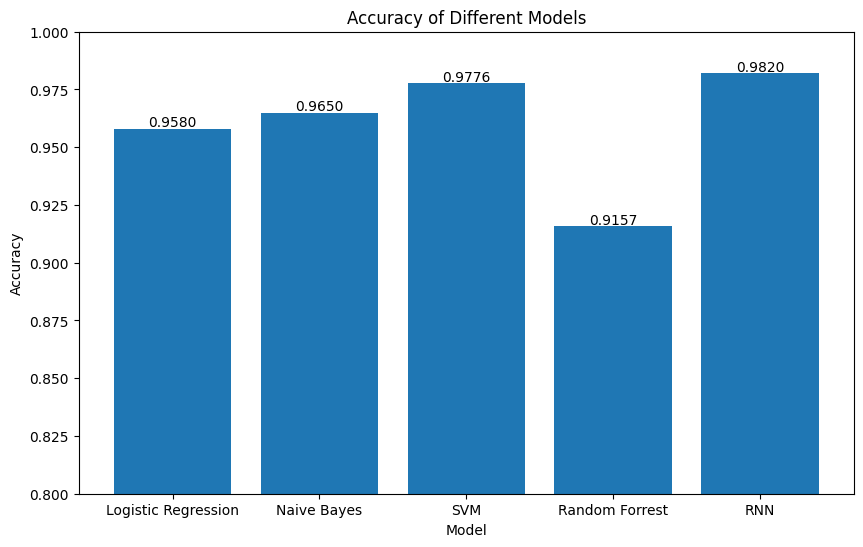

In [5]:
import matplotlib.pyplot as plt

# Model names
models = ['Logistic Regression', 'Naive Bayes', 'SVM','Random Forrest', 'RNN']

# Accuracy of each model
accuracy = [0.958, 0.965, 0.9776,0.9157, 0.982]  # Assuming RNN accuracy as 98% for demonstration

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0.8, 1)
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.001, f'{acc:.4f}', ha = 'center')
plt.savefig('accuracy.png')
plt.show()
